# **OtterBots Group Project**
## <em>Can a dog's attributes predict their intelligence?</em><br>
CST383: Introduction to Data Science<br>
Professor Ergezer<br>
Kevin Mcnulty, Nadia Rahbany, Juli Shinozuka, Andrew Shiraki<br>
02/14/2023<br><br>

<b>Introduction</b>: Have you ever wondered if there are attributes that can help predict intelligence in a companion dog?  What we hope to discover is whether attributes like height, weight, demeanor, and energy level can indicate a dog's intelligence level.  Intelligence (or obedience) is the likelihood that a dog will obey commands and require fewer repititions to learn new commands.  The intelligence scoring does not take into account that some dogs are bred for tasks that does not require 'obedience' to humans and rely more on independent thinking to do their purpose.<br><br>

<b>Datasets</b>: After data munging and cleaning is done and the three datasets used are merged into a final dataset, we assessed the attributes that might help in our analysis.  We discovered that 'Classification', 'obey', and the rep columns are all related, and thus we only need to use one as the target.  Our data exploration has revealed that 'weight_avg', 'height_avg', 'demeanor_value', and 'energy_level_value' can be possible predictors.  More exploration is needed to determine the best combination.<br><br>
<b>Methods</b>: The machine learning algorithms we will use to train models that will predict dog intelligence via attributes will be kNN and Linear Regression.<br><br>

Our goal is to train models that will predict the intelligence of a dog using selected features (height, weight, demeanor, and energy) as accurately as possible given the small dataset available.<br><br>

Source of the CSV files:

*   [Kaggle - Canine Intelligence and Size](https://www.kaggle.com/datasets/thedevastator/canine-intelligence-and-size?select=AKC+Breed+Info.csv) on Jan 31, 2023 (6pm)
*   [Github - akcdata by tmfilho](https://github.com/tmfilho/akcdata) on Feb 4, 2023 (5pm)









---


## **Import Libraries**

In [50]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix

In [51]:
# surpress warnings
import warnings
warnings.filterwarnings('ignore')




---


## **Data Processing and Cleaning**



*   Create dataframes from the csv files



In [52]:
# URLs
breed_info_url="./data/AKC_Breed_Info.csv"
intel_url = "./data/dog_intelligence.csv"
groups_url = "./data/akc-data-latest.csv"

In [53]:
# create dataframes
df1 = pd.read_csv(breed_info_url, index_col=0)
df2 = pd.read_csv(intel_url, index_col=0)
#df2.drop(columns=['obey'], inplace=True) # drop 'obey' column.
df3 = pd.read_csv(groups_url)



*   Clean and prepare df3 for later merger.



In [54]:
# Cleaning up df3 for what is needed or possibly useful
df3.rename(columns={'Unnamed: 0': 'Breed'}, inplace=True)
df3 = df3[['Breed', 'group', 'energy_level_value', 'demeanor_value']]
df3.drop(df3[df3['group'] == 'Foundation Stock Service'].index, inplace=True)
df3.dropna(inplace=True)

*   Rename entries where a dog breed has many different spellings across the dataframes

In [55]:
# Fix different spellings of the same breed to increase useable entries

# Mismatched spelling of breeds that are affected by merger of df1 and df2 = dd
df1['Breed'] = df1['Breed'].str.replace('Airdale Terrier', 'Airedale Terrier')
df1['Breed'] = df1['Breed'].str.replace('Cocker Spaniel-American', 'Cocker Spaniel')
df1['Breed'] = df1['Breed'].str.replace('Cocker Spaniel-English', 'English Cocker Spaniel')
df1['Breed'] = df1['Breed'].str.replace('Collie \(Rough\) & \(Smooth\)', 'Collie')
df1['Breed'] = df1['Breed'].str.replace('Old English Sheepdog \(Bobtail\)', 'Old English Sheepdog')
df1['Breed'] = df1['Breed'].str.replace('Shetland Sheepdog \(Sheltie\)', 'Shetland Sheepdog')

df2['Breed'] = df2['Breed'].str.replace('Chinese Shar Pei', 'Chinese Shar-Pei')
df2['Breed'] = df2['Breed'].str.replace('Curly Coated Retriever', 'Curly-Coated Retriever')
df2['Breed'] = df2['Breed'].str.replace('Soft-coated Wheaten Terrier', 'Soft Coated Wheaten Terrier')

# Breeds affected by merger of dd and df3 = dd
df1['Breed'] = df1['Breed'].str.replace('Chinese Shar Pei', 'Chinese Shar-Pei')
df1['Breed'] = df1['Breed'].str.replace('Curly Coated Retriever', 'Curly-Coated Retriever')
df1['Breed'] = df1['Breed'].str.replace('Flat Coated Retriever', 'Flat-Coated Retriever')
df1['Breed'] = df1['Breed'].str.replace('Otter Hound', 'Otterhound')
df1['Breed'] = df1['Breed'].str.replace('Soft-Coated Wheaten Terrier', 'Soft Coated Wheaten Terrier')

# Breeds in that don't make an impact since they are not in df2
df1['Breed'] = df1['Breed'].str.replace('Anatolin Sheepdog', 'Anatolian Shepherd Dog')

*   Create new dataframe from merging the three initial dataframes on 'Breed' column

In [56]:
dd = pd.merge(df1,df2, on='Breed')
dd = pd.merge(dd, df3, on='Breed')



*   Replace all 'na', 'not found' to NaN



In [57]:
dd.replace({'na': 'not found'}, inplace=True)
dd.replace({'not found': np.nan}, inplace=True)



*   Drop entry ('Alaskan Malamute') because it is missing height and weight data



In [58]:
dd.dropna(subset=['height_low_inches'], inplace=True)
dd.reset_index(drop=True, inplace=True)



*   Fixed error in values in certain breeds.  Some had height and weight values swapped.

** Since data is supposed to reflect AKC values, the fixes were done using values found from the AKC website for those breeds.

[AKC website link](https://www.akc.org) where corrected data came from. (Feb 14, 2023)





In [59]:
dd.loc[dd[dd['Breed'] == 'Vizsla'].index,['height_low_inches']] = 21
dd.loc[dd[dd['Breed'] == 'Vizsla'].index,['height_high_inches']] = 24
dd.loc[dd[dd['Breed'] == 'Vizsla'].index,['weight_low_lbs']] = 44
dd.loc[dd[dd['Breed'] == 'Vizsla'].index,['weight_high_lbs']] = 60

dd.loc[dd[dd['Breed'] == 'Irish Water Spaniel'].index,['height_low_inches']] = 21

dd.loc[dd[dd['Breed'] == 'Dandie Dinmont Terrier'].index,['height_low_inches']] = 8
dd.loc[dd[dd['Breed'] == 'Dandie Dinmont Terrier'].index,['height_high_inches']] = 11
dd.loc[dd[dd['Breed'] == 'Dandie Dinmont Terrier'].index,['weight_low_lbs']] = 18
dd.loc[dd[dd['Breed'] == 'Dandie Dinmont Terrier'].index,['weight_high_lbs']] = 24

dd.loc[dd[dd['Breed'] == 'Pomeranian'].index,['height_low_inches']] = 6
dd.loc[dd[dd['Breed'] == 'Pomeranian'].index,['height_high_inches']] = 7



*   Convert height and weight columns to floats



In [60]:
dd['height_low_inches'] = dd['height_low_inches'].astype(str).astype(float)
dd['height_high_inches'] = dd['height_high_inches'].astype(str).astype(float)
dd['weight_low_lbs'] = dd['weight_low_lbs'].astype(str).astype(float)
dd['weight_high_lbs'] = dd['weight_high_lbs'].astype(str).astype(float)

*   Remove '%' from the 'obey' column
*   Convert 'obey' column to floats
*   Change nan in 'obey' to value 0 (these dogs are rated 0%)

In [61]:
# first remove the '%' character
dd['obey'] = dd['obey'].str.replace('%', '')

# then covert to float
dd['obey'] = dd['obey'].astype(str).astype(float)

# change nan in 'obey' to 0
dd['obey'].fillna(0.0, inplace=True)

### **Adding Features**


*   Average weight
*   Average height
*   Average reps
*   Height to weight ratio





In [62]:
dd['weight_avg'] = (dd['weight_high_lbs'] + dd['weight_low_lbs']) / 2
dd['height_avg'] = (dd['height_high_inches'] + dd['height_low_inches']) / 2
dd['reps_avg'] = (dd['reps_lower'] + dd['reps_upper']) / 2
dd['height_to_weight'] = dd['height_avg'] / dd['weight_avg']



---


## **Data Fields of 'dd'**

Rows: 113

Columns (15):


*   'Breed' - Name of AKC dog breed. (string)
*   'height_low_inches' - The lower range of dog's height. (float)
*   'height_high_inches' - The upper range of a dog's height. (float)
*   'weight_low_lbs' - The lower range of dog's weight. (float)
*   'weight_high_lbs' - The upper range of dog's weight. (float)
*   'Classification' - The size calculation of the dog according to AKC. (string)
*   'obey' - The probability that the breed obeys the first command. (float)
*   'reps_lower' - The lower limit of repetitions to understand a new command. (int)
*   'reps_upper' - The upper limit of repetitions to understand a new command. (int)
*   'group' - The AKC group the breed is in. (string)
*   'energy_level_value' - A number representing the breed's energy level. (float)
*   'demeanor_value' - A number representing the breed's reaction to strangers and other pets. (float)
*   'weight_avg' - The average of lower and upper range of dog's weight.
*   'height_avg' - The average of lower and upper range of dog's height.
*   'reps_avg' - The average of lower and upper range of dog's repetitions to understand a new command.  (float)
*   'height_to_weight' - The height_avg / weight_avg.  (float)

**NOTE**: 'Classification', 'obey' and all the 'reps' columns show the same information in different ways.  One should only be used as the target and not also a feature.


**Classification (df2) of 'obey' and reps**<br>
Brightest Dogs                                   95%     1 to   4<br>
Excellent Working Dogs                           85%     5 to  15<br>
Above Average Working Dogs                       70%    16 to  25<br>
Average Working/Obedience Intelligence           50%    26 to  40<br>
Fair Working/Obedience Intelligence              30%    41 to  80<br>
Lowest Degree of Working/Obedience Intelligence   0%    81 to 100<br>
<br>
**Energy Level**<br>
1.0 Needs Lots of Activity<br>
0.8 Energetic<br>
0.6 Regular Exercise<br>
0.4 Calm<br>
0.2 Couch Potato<br>
<br>
**Demeanor**<br>
1.0 Outgoing<br>
0.8 Friendy<br>
0.6 Alert/Responsive<br>
0.4 Reserved with Strangers<br>
0.2 Aloof/Wary<br>



---


## **Data Exploration**

In [63]:
#(j) display dataset information (cleaned)
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Breed               113 non-null    object 
 1   height_low_inches   113 non-null    float64
 2   height_high_inches  113 non-null    float64
 3   weight_low_lbs      113 non-null    float64
 4   weight_high_lbs     113 non-null    float64
 5   Classification      113 non-null    object 
 6   obey                113 non-null    float64
 7   reps_lower          113 non-null    int64  
 8   reps_upper          113 non-null    int64  
 9   group               113 non-null    object 
 10  energy_level_value  113 non-null    float64
 11  demeanor_value      113 non-null    float64
 12  weight_avg          113 non-null    float64
 13  height_avg          113 non-null    float64
 14  reps_avg            113 non-null    float64
 15  height_to_weight    113 non-null    float64
dtypes: float

In [64]:
#(j) show basic statistics of numeric columns
dd[['height_low_inches', 'height_high_inches', 'height_avg', 'weight_low_lbs', 'weight_high_lbs', 'weight_avg', 'height_to_weight']].describe()

,height_low_inches,height_high_inches,height_avg,weight_low_lbs,weight_high_lbs,weight_avg,height_to_weight
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,17.933628,20.517699,19.225664,41.964602,56.699115,49.331858,0.546711
std,6.042079,6.647344,6.304403,28.875635,38.795454,33.487245,0.339705
min,6.000000,7.000000,6.500000,2.000000,5.000000,3.500000,0.156164
25%,13.000000,15.000000,14.500000,18.000000,25.000000,22.500000,0.355556
50%,19.000000,21.000000,20.000000,40.000000,55.000000,50.000000,0.423529
75%,22.000000,26.000000,24.000000,60.000000,75.000000,65.000000,0.620000
max,32.000000,35.000000,32.000000,175.000000,190.000000,182.500000,2.142857


<AxesSubplot:>

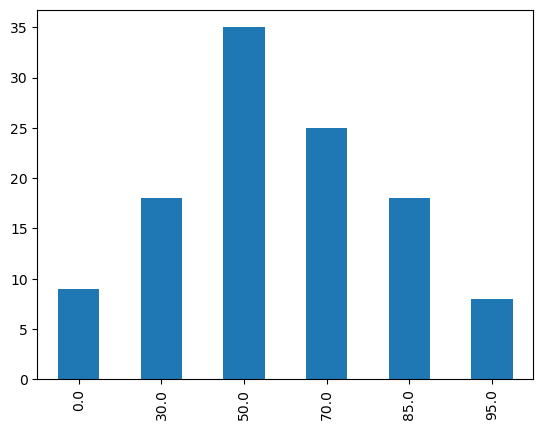

In [65]:
#(j) explore distribution of 'obey'
dd['obey'].value_counts().sort_index().plot(kind='bar')
# majority of dogs are average (50% obey)

In [66]:
#(j) view correlation matrix information for 'obey'
corr_matrix = dd.corr()
corr_matrix['obey'].sort_values()

# note: obey = reps values, so of course they have very high correlation,
# but they not useful for the analysis.
# Highest useable ones include:
#   energy_level_value: 0.30
#   demeanor_value: 0.15
#   height_high_inches: 0.10
#   height_to_weight: -0.10

reps_avg             -0.983670
reps_upper           -0.972253
reps_lower           -0.970795
height_to_weight     -0.097041
weight_low_lbs       -0.036676
weight_avg           -0.033024
weight_high_lbs      -0.029713
height_low_inches     0.072802
height_avg            0.085844
height_high_inches    0.096658
demeanor_value        0.146656
energy_level_value    0.299767
obey                  1.000000
Name: obey, dtype: float64

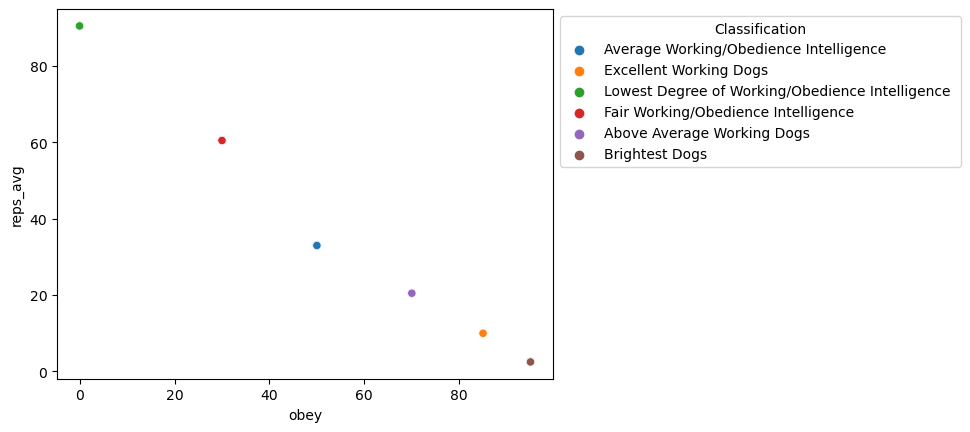

In [67]:
#(j) Note the correlation between these three features.
# Depending on need, we can interchange these features during modeling
# a prediction as they suit that type of modeling.
ax = sns.scatterplot(data=dd, x='obey', y='reps_avg', hue='Classification')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

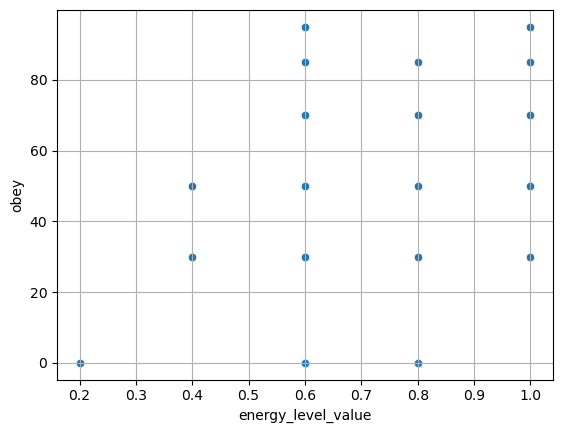

In [89]:
sns.scatterplot(data = dd, x = 'energy_level_value', y = "obey")
plt.grid()

The following bar chart provides insight on dog intelligence by comparing the average obey score of different breed groups in the data set to visualize which breed group is most obedient.

Text(0, 0.5, 'Avg Obedience Score')

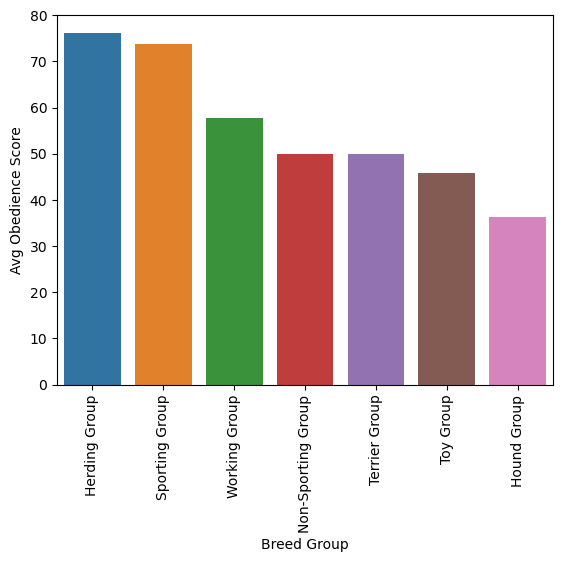

In [69]:
fig, ax = plt.subplots()
group_obey = dd.groupby('group')['obey'].mean().sort_values(ascending=False)
sns.barplot(x=group_obey.index, y=group_obey.values, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel('Breed Group')
ax.set_ylabel('Avg Obedience Score')


This visualization groups data by breed group, and calculates the mean obey score and energy level score to show the relationship between the average obedience and energy level for each breed group. 

Text(0, 0.5, 'Average Obedience Score')

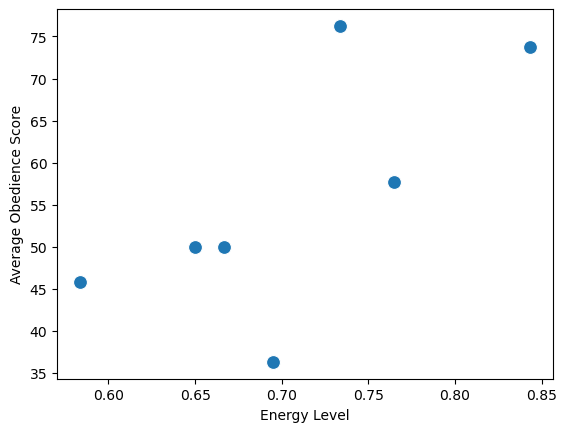

In [70]:
group_data = dd.groupby('group').mean()[['obey', 'energy_level_value']].reset_index()
sns.scatterplot(data=group_data, x='energy_level_value', y='obey', s=100)
plt.xlabel('Energy Level')
plt.ylabel('Average Obedience Score')

The following visualization is a scatter plot that is comparing the dog breeds intelligence by their weight.

Text(0, 0.5, 'Intelligence')

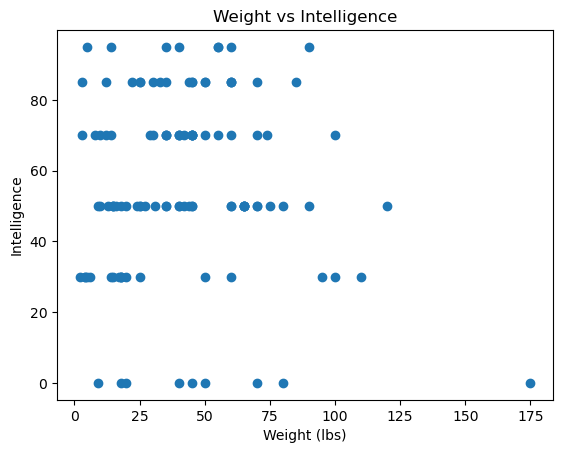

In [71]:
plt.scatter(dd["weight_low_lbs"], dd["obey"])
plt.title("Weight vs Intelligence")
plt.xlabel("Weight (lbs)")
plt.ylabel("Intelligence")

The following visualization is a scatter plot which displays the breed by obedience and the dogs demeanor

Text(0.5, 1.0, 'Dog Breed by Obedience and Demeanor')

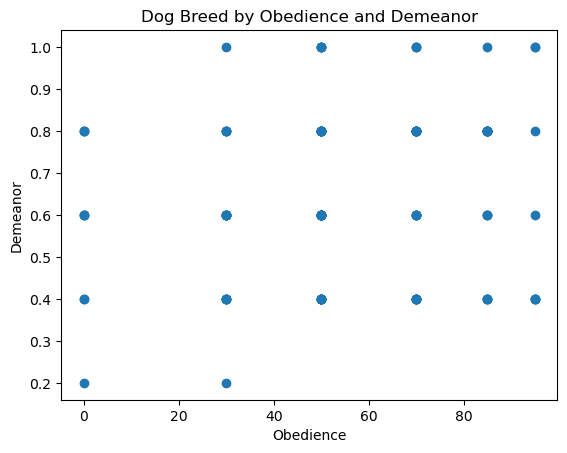

In [72]:
plt.scatter(dd.obey, dd.demeanor_value)
plt.xlabel('Obedience')
plt.ylabel('Demeanor')
plt.title('Dog Breed by Obedience and Demeanor')

The following bar plot displays the breeds that are most energetic and are sorted by descending energy level.

Text(0.5, 1.0, 'Most Energetic Dog Breeds by Breed Group')

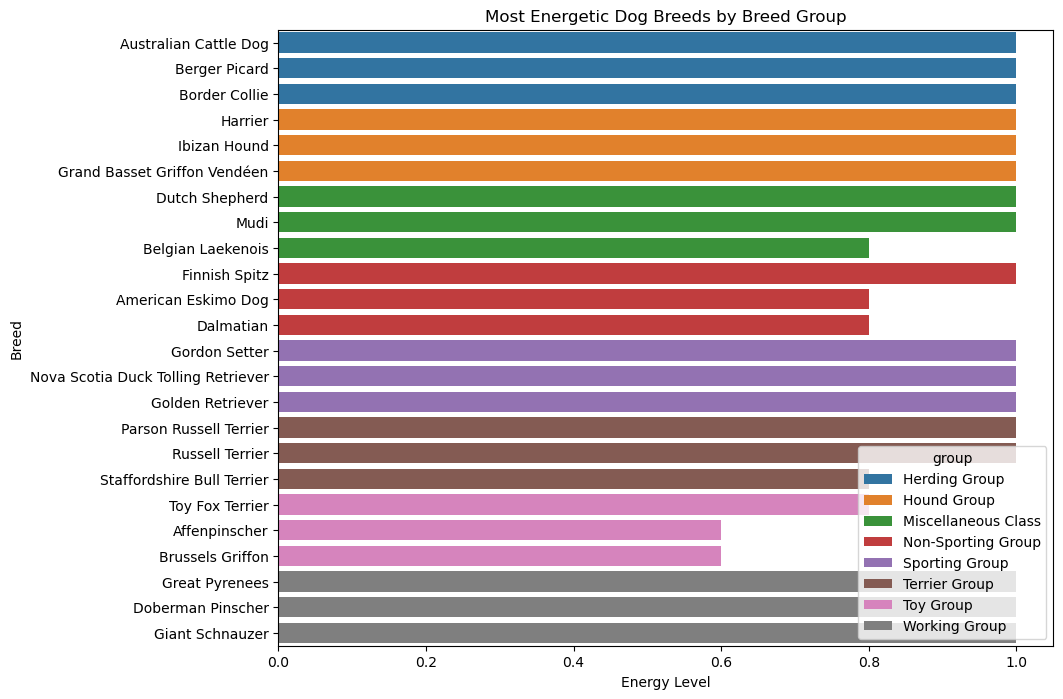

In [73]:
sorted_df = df3.groupby('group').apply(lambda x: x.sort_values('energy_level_value', ascending=False)).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='energy_level_value', y='Breed', hue='group', data=sorted_df.groupby('group').head(3), dodge=False)
plt.xlabel('Energy Level')
plt.ylabel('Breed')
plt.title('Most Energetic Dog Breeds by Breed Group')

This heatmap is a visual represenation of the average obedience score for each breed group and weight range. It's filtered for breeds with an average weight of 30 to 60lbs. 

Text(158.22222222222223, 0.5, 'Breed')

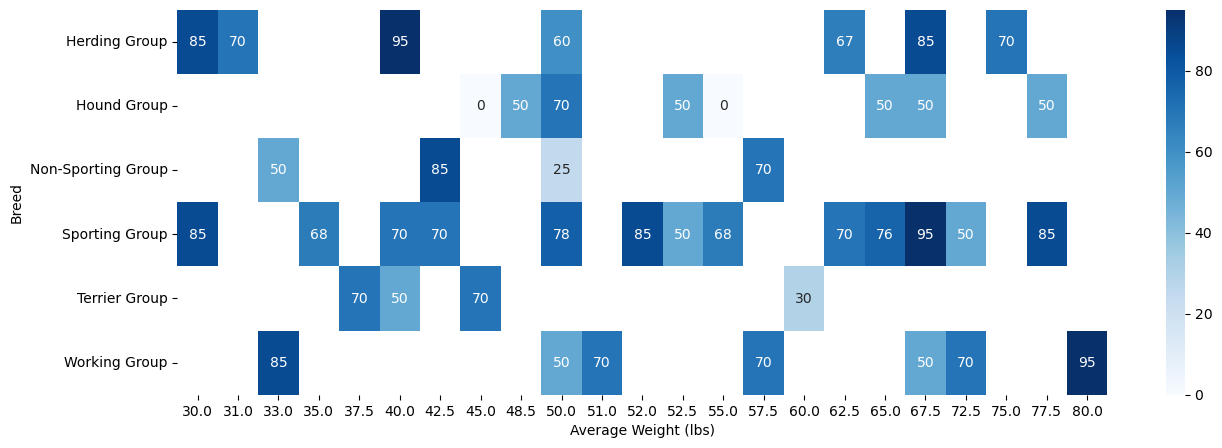

In [74]:
data_group = dd.groupby(['group', 'weight_avg']).mean().reset_index()
filtered = data_group [(data_group ['weight_avg'] >= 30) & (data_group ['weight_avg'] <= 80)]
heat_data = filtered.pivot_table(values='obey', index='group', columns='weight_avg')
plt.figure(figsize=(15,5))
sns.heatmap(heat_data, cmap='Blues', annot=True, fmt='.0f')
plt.xlabel('Average Weight (lbs)')
plt.ylabel('Breed')



---

## **Modeling**


*   kNN Classification Model
*   kNN Regression Model
*   Linear Regression Model
*   Polynomial Transformation
*   Decision Tree Classifier??
*   ??????????????????????

Due to the dataset being a small size (113 data points), the train/test split chosen was 80/20.


In [75]:
# Functions used by some of the models
def rmse(predicted, actual):
  return np.sqrt(((predicted - actual)**2).mean())

---
### kNN Classification Model
Using target 'Classification' which is a category and comparable to 'obey'.<br>
Predict what classification (of obedience) a dog is using the predictors.

In [76]:
predictors = ['energy_level_value', 'demeanor_value', 'height_to_weight']
target = 'Classification'
X = dd[predictors].values
y = dd[target].values;

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for k in range(1,9,2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  predictions = knn.predict(X_test)
  accuracy = knn.score(X_test, y_test)
  print('k = {}, accuracy = {:.2f}'.format(k, accuracy))

# predictors = ['energy_level_value', 'demeanor_value']
# k = 1, accuracy = 0.22
# k = 3, accuracy = 0.26
# k = 5, accuracy = 0.26
# k = 7, accuracy = 0.26

# predictors = ['energy_level_value', 'demeanor_value', 'height_to_weight']
# k = 1, accuracy = 0.35
# k = 3, accuracy = 0.39
# k = 5, accuracy = 0.48
# k = 7, accuracy = 0.39

# predictors = ['energy_level_value', 'demeanor_value', 'height_avg', 'weight_avg']
# k = 1, accuracy = 0.17
# k = 3, accuracy = 0.43
# k = 5, accuracy = 0.48
# k = 7, accuracy = 0.39

k = 1, accuracy = 0.35
k = 3, accuracy = 0.39
k = 5, accuracy = 0.48
k = 7, accuracy = 0.39


The ideal predictors seem to be: 'energy_level_value', 'demeanor_value', 'height_to_weight'.<br>
With k = 5, the accuracy is at 48%.  Not great, but better than other attempts on this model.

k = 5, accuracy = 0.48


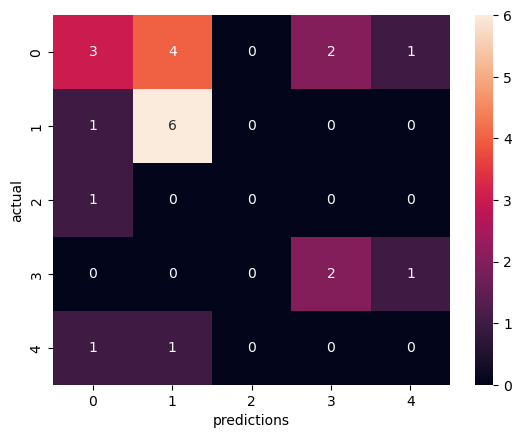

In [77]:
# kNN classification model for a 'decent' modeling.
predictors = ['energy_level_value', 'demeanor_value', 'height_to_weight']
target = 'Classification'
X = dd[predictors].values
y = dd[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print('k = 5, accuracy = {:.2f}'.format(accuracy))

# Confusion Matrix to view where the values differed between actual and
# predicted.
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True)
plt.xlabel('predictions')
plt.ylabel('actual')
plt.show()

The test size was 20%, which is 23 out of 113.  The largest misclassification comes where the data should be 0 but is predicted as 1, at 7/10 being misclassifed.  There is an imbalance in the test dataset with 43% of the test being in category 0.  Then the next largest is 30% for 1.  The majority of category 1 is predicted correctly.  There is only one data point in 2 with it being categorized wrong.  Category 3 was 33% incorrect and category 4 was 100% incorrect with 2 data points.<br><br>
The kNN classification model is not well suited to our problem.  The dataset for training and testing is small.

---
### kNN Regression Model
Using target 'obey' which is numeric and comparable to 'Classification'.<br>
Predict the value of 'obey' is using the predictors.

In [78]:
# select the predictor variables and target variables to be used with regression
predictors = ['energy_level_value', 'demeanor_value', 'height_to_weight']
target = 'obey'
X = dd[predictors].values
y = dd[target].values

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# scaled version
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# blind prediction of rmse baseline of training data
base_rmse = rmse(y_train.mean(), y_test)
print('RMSE baseline (test): {:.2f}'.format(base_rmse))

for k in range(1,10,2):
  knn = KNeighborsRegressor(n_neighbors=k, algorithm="brute")
  knn.fit(X_train, y_train)
  predictions = knn.predict(X_test)
  RMSE = rmse(predictions, y_test)
  print('k = {}, RMSE = {:.2f}'.format(k, RMSE))

# predictors = ['energy_level_value', 'demeanor_value', 'height_to_weight']
# RMSE baseline (test): 19.04
# k = 1, RMSE = 28.87
# k = 3, RMSE = 22.34
# k = 5, RMSE = 20.51
# k = 7, RMSE = 19.57
# k = 9, RMSE = 21.24

# predictors = ['energy_level_value', 'demeanor_value', 'weight_avg', 'height_avg']
# RMSE baseline (test): 19.04
# k = 1, RMSE = 35.93
# k = 3, RMSE = 24.13
# k = 5, RMSE = 19.67
# k = 7, RMSE = 19.76
# k = 9, RMSE = 19.85

RMSE baseline (test): 19.04
k = 1, RMSE = 28.87
k = 3, RMSE = 22.34
k = 5, RMSE = 20.51
k = 7, RMSE = 19.57
k = 9, RMSE = 21.24


In [79]:
def get_train_test_rmse(regr, X_train, X_test, y_train, y_test):
    rmse = np.zeros(2)
    regr.fit(X_train, y_train)
    predict = regr.predict(X_train)
    rmse[0] = np.sqrt(((predict - y_train)**2).mean())
    predict = regr.predict(X_test)
    rmse[1] = np.sqrt(((predict - y_test)**2).mean())
    return rmse

n = 10
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)

def get_best(ks, rmse):
    best = []
    min_rmse = min(rmse)
    best.append(ks[rmse.index(min_rmse)])
    best.append(min_rmse)
    return best

best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

# predictors = ['energy_level_value', 'demeanor_value', 'height_to_weight']
# best k = 7, best test RMSE: 19.6

# predictors = ['energy_level_value', 'demeanor_value', 'weight_avg', 'height_avg']
# best k = 5, best test RMSE: 19.7

best k = 7, best test RMSE: 19.6


best k = 5, best test RMSE: 19.7


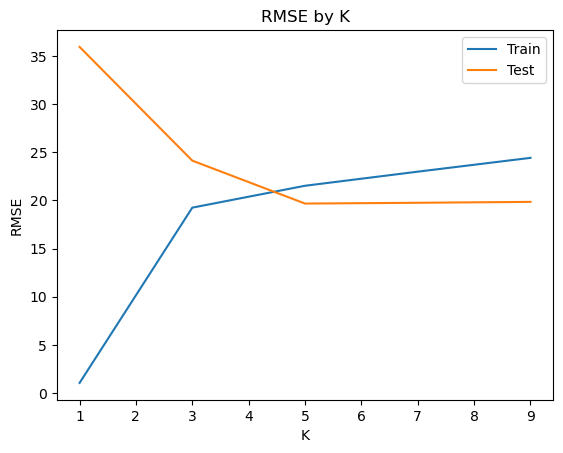

In [80]:
# kNN regression model using one of the predictor sets.
predictors = ['energy_level_value', 'demeanor_value', 'weight_avg', 'height_avg']
target = 'obey'
X = dd[predictors].values
y = dd[target].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

n = 10
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)

best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

# plot RMSE by K
plt.plot(ks, train_rmse, label='Train')
plt.plot(ks, test_rmse, label='Test')
plt.title('RMSE by K')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.legend()
plt.show()

The two models trained have the best RMSE at about k = 5 or k = 7 with the RMSE at about 19.7.  This is close to the rmse baseline.<br><br>
There is some concern on overfitting and why the two lines cross.  I think k = 3 seems to be a good spot.<br><br>
** The kNN regression models seems to be objectivly worse than the linear regression models.



---


### Linear Regression Model

In [81]:
features = ['energy_level_value', 'demeanor_value', 'weight_avg', 'height_avg']
#features = ['energy_level_value', 'demeanor_value', 'height_to_weight']
X = dd[features]
y = dd['obey'].values

#Scale X to understand weights better
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# compute training/test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# train model
reg = LinearRegression()
reg.fit(X_train, y_train)
prediction = reg.predict(X_test)

# display results
print('-----------')
print("r-square = {:.4f}".format(reg.score(X_train, y_train)))
print('-----------')
rmse = np.sqrt(((prediction - y_test)**2).mean())
print('rmse: {:.4f}'.format(rmse))
print('-----------')
print('Intercept: {:.2f}'.format(reg.intercept_))
print('Coefficients')
for i, feature in enumerate(features):
  print('\t{}: {:.2f}'.format(feature, reg.coef_[i]))
print('-----------')

# features = ['energy_level_value', 'demeanor_value', 'weight_avg', 'height_avg']
# r-square = 0.1897
# rmse = 21.9265
# Intercept: 53.80
# Coefficients
#	  energy_level_value: 8.29
#	  demeanor_value: 5.10
#	  weight_avg: -9.77
#	  height_avg: 8.85

# features = ['energy_level_value', 'demeanor_value', 'height_to_weight']
# r-square = 0.1636
# rmse = 21.5473
# Intercept: 54.05
# Coefficients
#   energy_level_value: 9.29
#   demeanor_value: 4.63
#	  height_to_weight: -1.44

-----------
r-square = 0.1897
-----------
rmse: 21.9265
-----------
Intercept: 53.80
Coefficients
	energy_level_value: 8.29
	demeanor_value: 5.10
	weight_avg: -9.77
	height_avg: 8.85
-----------


The r-squared value is far below the acceptable 0.6 value.  The r-squared for different combinations of features did not exceed 0.19.  That is extremely bad.

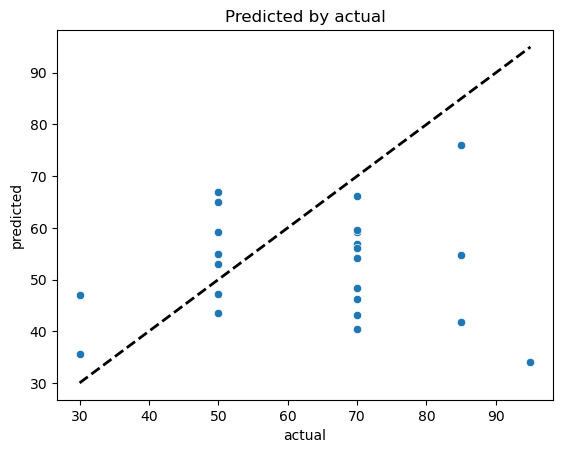

In [82]:
# plot predicted by actual
def plot_actual_predicted(actual, predicted, title):
    min_point = min(predicted.min(), actual.min())
    max_point = max(predicted.max(), actual.max())
    
    sns.scatterplot(x=actual, y=predicted)
    plt.plot([min_point, max_point], [min_point, max_point], 'k--', linewidth=2)
    plt.title(title)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    
plot_actual_predicted(y_test, prediction, 'Predicted by actual')

Each feature was tested individually to see if any are strongly correlated.  The 'energy_level_value' had the strongest correlation, but even on its own it did not noticeably improve the model.  The dataset is not suited to this model since its values do not behave in a linear fashion.

### Polynomial Transformation

Incase the data is nonlinear, try to fit polynomial. RMSE went up rapidly with polynomial degree indicating the data is likely more linear than anything else

In [83]:
features = ['energy_level_value', 'demeanor_value', 'weight_avg', 'height_avg']
#features = ['energy_level_value', 'demeanor_value', 'height_to_weight']
target = 'obey'
X = dd[features].values
y = dd[target].values

# make a model of polynomial features
pf = PolynomialFeatures(degree=2, include_bias=False)
pf.fit(X)

# transform X so that it has many more features
X_poly = pf.transform(X)

# compute traning/test data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=0.2, random_state=42)

# train model
reg = LinearRegression()
reg.fit(X_train, y_train)
predict_tr = reg.predict(X_train)
predict_te = reg.predict(X_test)

# display r-squared and rmse
print('Polynomial Feature Scores')
print("r-square = {:.4f}".format(reg.score(X_train, y_train)))
rmse_tr = np.sqrt(((predict_tr - y_train)**2).mean())
print("RMSE train: {:.4f}".format(rmse_tr))
rmse_te = np.sqrt(((predict_te - y_test)**2).mean())
print("RMSE test: {:.4f}".format(rmse_te))

Polynomial Feature Scores
r-square = 0.8355
RMSE train: 9.8968
RMSE test: 90.7317


$r^2$ improved a lot but RMSE is worse. The difference in the rmse between the train and test seems to indicate we have overfitted.

In [84]:
# check if overfitting by comparing training and test performance
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

# train model
reg = LinearRegression()
reg.fit(X_train, y_train)
predict_tr = reg.predict(X_train)
predict_te = reg.predict(X_test)

# display r-squared and rmse
print('Linear Regression Scores')
print("r-square = {:.4f}".format(reg.score(X_train, y_train)))
rmse_tr = np.sqrt(((predict_tr - y_train)**2).mean())
print("RMSE train: {:.4f}".format(rmse_tr))
rmse_te = np.sqrt(((predict_te - y_test)**2).mean())
print("RMSE test: {:.4f}".format(rmse_te))

Linear Regression Scores
r-square = 0.1761
RMSE train: 22.1469
RMSE test: 25.6570



### Decision Tree Classifier




1. Set up baseline for working decision tree classifier model

In [85]:
# get predictor and target data
predictors = ['energy_level_value', 'demeanor_value', 'weight_avg', 'height_avg']
target = ['Classification']
X = dd[predictors]
y = dd[target].values

#split it
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [86]:
# Create DT classifier and train it
DT = DecisionTreeClassifier(max_depth=5, random_state=0)
DT.fit(X_train,y_train)
#convert to pd Series
predictions = pd.Series(DT.predict(X_test), name='Predicted')
actual = pd.Series(y_test.reshape(1,-1)[0], name='Actual')
accuracy = (predictions == actual).sum() / predictions.shape[0]


2. Now that we have a working model, iterated through depths to see where we get the most accuracy

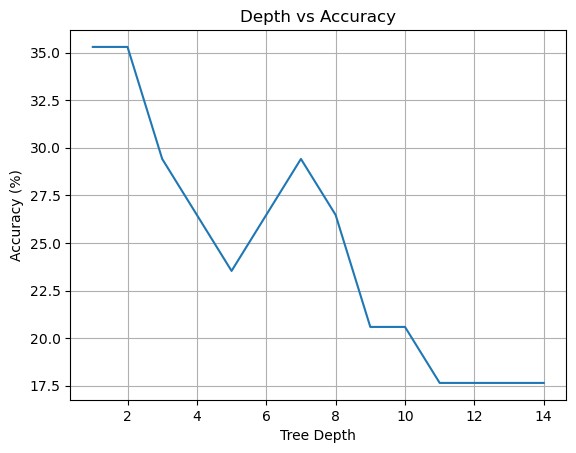

In [87]:
depths={}
for i in range(1,15):
  DT = DecisionTreeClassifier(max_depth=i, random_state=0)
  DT.fit(X_train,y_train)
  predictions = pd.Series(DT.predict(X_test), name='Predicted')
  actual = pd.Series(y_test.reshape(1,-1)[0], name='Actual')
  depths[i] = 100* ((predictions == actual).sum() / predictions.shape[0])
plt.plot(list(depths.keys()), list(depths.values()))
plt.grid()
plt.title('Depth vs Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Tree Depth');


- The highest accuracy we were able to acchieve was at a tree depth of 2 
  - Accuracy was determined by `100*((predictions == actual).sum() / predictions.shape[0])` 
- Suspect this is entirely due to limiting the number of buckets we can choose from, forcing the model to sort everything into the middle classifications which have the most entries. Similar to the saying:
>"A broken clock is right twice a day"

3. Generate the depth 2 Decisions Tree Classifier to visualize it:

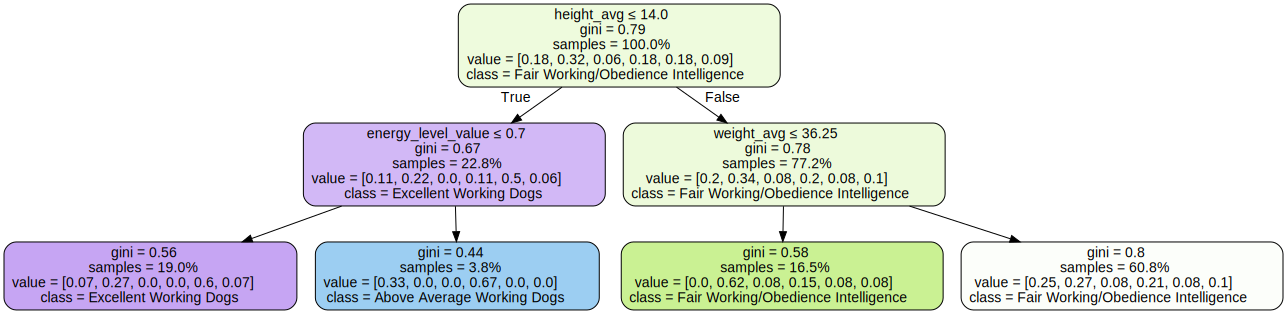

In [88]:
#Re-generate tree for visualization
DT = DecisionTreeClassifier(max_depth=2, random_state=0)
DT.fit(X_train,y_train)
#visualize tree
dot_data = export_graphviz(DT, precision=2,
                 feature_names=predictors,  
                 proportion=True,  
                 filled=True, rounded=True,  
                 special_characters=True,
                 class_names = list(dd.sort_values('obey')['Classification'].unique()))
                 
# plot it
graph = graphviz.Source(dot_data)  
graph



---

## **Evaluation**



---

## **Make a report and video????**
also update github stuff?  so much to do.